# Installing the important libraries


In [52]:
"""
conda install -c conda-forge swig -y
conda install -c conda-forge box2d-py -y
python -m pip install --upgrade pip setuptools wheel
python -m pip install gymnasium[box2d]
"""

'\nconda install -c conda-forge swig -y\nconda install -c conda-forge box2d-py -y\npython -m pip install --upgrade pip setuptools wheel\npython -m pip install gymnasium[box2d]\n'

# Importing the important modules


In [53]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import os
import math
import pickle

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation of the Car Racing game from Gymnasium using Deep Q Learning with CNN

## Understanding Dueling DQN vs. Standard DQN

In traditional Reinforcement Learning, the agent tries to learn the Action-Value function, denoted as $Q(s, a)$. This value represents the expected total reward the agent will receive by taking action $a$ in state $s$. However, in many states, the specific action chosen does not significantly impact the outcome. For example, in a car racing game, whether the car steers slightly left or right while on a straight stretch of road might not change the overall "value" of that state.

### The Standard DQN Approach

In a standard Deep Q-Network (DQN), the neural network treats every state-action pair as a unique entity to be learned. The architecture consists of:

- **Convolutional Layers:** Extract spatial features from the game frames.

- **Fully Connected Layers:** Map these features directly to a set of $Q(s, a)$ values—one for every possible move (e.g., steer left, steer right, gas, brake).

### The Dueling DQN Innovation

The Dueling DQN architecture changes how the network calculates these values by splitting the final layers into two separate streams:

- **State Value Stream ($V(s)$):** This stream predicts how "good" it is to be in a certain state, regardless of which action is taken.

- **Advantage Stream ($A(s, a)$):** This stream predicts the relative importance (advantage) of each action compared to the others in that specific state.

By separating these two, the agent can learn which states are valuable even if it hasn't explored every single action in those states yet. This makes the learning process much more efficient.

### The Aggregation Layer

To get the final Q-values used for decision-making, we combine the two streams using a specific formula:

$$Q(s, a) = V(s) + \left( A(s, a) - \frac{1}{|A|} \sum_{a'} A(s, a') \right)$$

Why subtract the mean? 

We subtract the average advantage to "center" the values. This ensures that the $V(s)$ stream truly captures the average value of the state, while the $A(s, a)$ stream focuses purely on the differences between actions.Key 

### Differences between Dueling and normal DQN


In the Standard DQN, the agent learns the "Quality" of a state-action pair $Q(s, a)$ as a single value. In the Dueling DQN, the network is forced to learn two separate things:

- State Value ($V$): How good is it to be in this position?
- Advantage ($A$): How much better is "Steer Left" compared to "Steer Right" in this specific moment?T

his separation is particularly effective for racing. For example, when driving at high speeds on a straight stretch of track, the "Value" of being on the road is very high, regardless of whether the agent chooses to steer slightly left or right. The Dueling DQN recognizes this redundancy, leading to more stable and efficient training.

---

## 1. Setup and Preprocessing

### Observation Space:
- A top-down 96x96 RGB image of the car and race track.

To make learning efficient, we can't just throw raw RGB frames at the network. The following section handles State Representation:

- **Preprocessing:** We convert images to grayscale and resize them to $84 \times 84$ to reduce the computational load.
- **Frame Skipping:** The agent doesn't need to see every single frame to understand movement. We skip frames to speed up training.
- **Frame Stacking:** A single static image doesn't show velocity. By stacking the 4 most recent frames, we provide the network with temporal context (motion).

In [54]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

Set up the Environment Wrapper

In [55]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=3, stack_frames=4, no_operation=50, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info


## 2. The Brain: Dueling Newtork Architecture (CNN)

Unlike a standard DQN that outputs $Q(s, a)$ directly, a Dueling DQN splits the network into two streams:

- **Value Stream ($V(s)$):** Estimates how good it is to be in a certain state.
- **Advantage Stream ($A(s, a)$):** Estimates the relative benefit of each action compared to others in that state.

These are combined using the formula:$$Q(s, a) = V(s) + (A(s, a) - \frac{1}{|A|} \sum A(s, a'))$$
This separation allows the agent to learn which states are valuable without having to learn the effect of each action for every single state.

In [56]:
class DuelingCNN(nn.Module):

  def __init__(self, in_channels, out_channels, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.n_features = 32 * 9 * 9

    self.conv = nn.Sequential(
      nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
      nn.ReLU(),
      nn.Conv2d(16, 32, kernel_size=4, stride=2),
      nn.ReLU(),
    )


    self.v = nn.Sequential(
      nn.Linear(self.n_features, 256),
      nn.ReLU(),
      nn.Linear(256, 1)
    )

    self.a = nn.Sequential(
        nn.Linear(self.n_features, 256),
        nn.ReLU(),
        nn.Linear(256, self.out_channels)
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.view((-1, self.n_features))
    val = self.v(x)
    adv = self.a(x)
    q = val + (adv - adv.mean())

    return q



## 3. Stabilizing Learning: Replay Memory

One major challenge in RL is that consecutive experiences are highly correlated (e.g., if you are turning left now, you are likely still turning left in the next frame). This breaks the "Independent and Identically Distributed" (IID) assumption required for neural network training.
- We use Experience Replay to store transitions $(s, a, s', r)$ in a buffer.
- During training, we sample random batches, which breaks the correlation between samples and leads to more stable convergence.

In [57]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## 4. The DQN Algorithm Logic
This is the core of the agent, it is the function responsible for selecting an action based on the observation state. It implements two critical DQN features:
1. **Epsilon-Greedy Strategy:** To balance Exploration (trying new things) and Exploitation (using what we know). Notice how eps_threshold decays over time.
2. **Target Network:** To prevent the "moving target" problem, we use two identical networks. The network is updated every step, while the target_network stays fixed and is only updated every $C$ steps to provide stable ground-truth labels.

In [ ]:
class DQN:
  def __init__(self, action_space, batch_size=256, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=1000, lr=0.001):
    self._n_observation = 4 # Stacked frames
    self._n_actions = 5 # Possible discretized actions
    self._action_space = action_space
    self._batch_size = batch_size # Batch size for training: Higher batch size means more stable training but requires more memory
    self._gamma = gamma # Discount factor for future rewards. The closer to 1 it is, the more the agent will consider future rewards
    self._eps_start = eps_start # Initial exploration probability
    self._eps_end = eps_end # Final exploration probability
    self._eps_decay = eps_decay # Decay rate for exploration probability
    self._lr = lr # Learning rate for the optimizer: Higher learning rate means faster learning but can lead to instability
    self._total_steps = 0
    self._evaluate_loss = []
    self.network = DuelingCNN(self._n_observation, self._n_actions).to(device) # Policy network
    self.target_network = DuelingCNN(self._n_observation, self._n_actions).to(device) # Target network
    self.target_network.load_state_dict(self.network.state_dict())
    self.optimizer = optim.AdamW(self.network.parameters(), lr=self._lr, amsgrad=True)
    self._memory = ReplayMemory(10000)


  def select_action(self, state, evaluation_phase=False):
    sample = random.random()
    eps_threshold = self._eps_end + (self._eps_start - self._eps_end) * math.exp(-1. * self._total_steps / self._eps_decay)
    self._total_steps += 1
    if evaluation_phase:
      with torch.no_grad():
        return self.target_network(state).max(1).indices.view(1, 1)
    elif sample > eps_threshold:
      with torch.no_grad():
        return self.network(state).max(1).indices.view(1, 1)
    else:
      return torch.tensor([[self._action_space.sample()]], device=device, dtype=torch.long)


  def train(self):
    if len(self._memory) < self._batch_size:
        return
    transitions = self._memory.sample(self._batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = self.network(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(self._batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * self._gamma) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    self.optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
    self.optimizer.step()

    self._evaluate_loss.append(loss.item())

    return

  def copy_weights(self):
    self.target_network.load_state_dict(self.network.state_dict())

  def get_loss(self):
    return self._evaluate_loss

  def save_model(self, i):
    os.makedirs('Dueling_DQN_model_weights', exist_ok=True)
    torch.save(self.target_network.state_dict(), f'Dueling_DQN_model_weights/model_weights_{i}.pth')
    path = f'Dueling_DQN_model_weights/model_weights_{i}.pth'

  def load_model(self, i):
    path = f'Dueling_DQN_model_weights/model_weights_{i}.pth'
    legacy = f'model_weights_{i}.pth'

    # Try the current path first
    if os.path.exists(path):
      self.target_network.load_state_dict(torch.load(path, map_location=device))
      return

    # Then try the legacy filename in cwd
    if os.path.exists(legacy):
      self.target_network.load_state_dict(torch.load(legacy, map_location=device))
      return

    # If neither exists, raise
    raise FileNotFoundError(f'Could not find model file {path} or {legacy}')


In [59]:
rewards_per_episode = []
episode_duration = []
average_episode_loss = []

episodes = 500
C = 5

env = gym.make('CarRacing-v3', continuous=False)
n_actions = env.action_space
agent = DQN(n_actions)


for episode in range(1, episodes + 1):
  if episode % 10 == 0:
    print(f"{episode} episodes done")

  env = gym.make('CarRacing-v3', continuous=False)
  env = CarEnvironment(env)

  state, info = env.reset()

  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

  episode_total_reward = 0.0

  for t in count():
    action = agent.select_action(state)
    observation, reward, terminated, truncated, _ = env.step(action.item())

    # keep a float copy for logging/plotting and a tensor for storage
    episode_total_reward += float(reward)
    reward_tensor = torch.tensor([reward], device=device)

    done = terminated or truncated

    if terminated:
      next_state = None
      print("Finished the lap successfully!")
    else:
      next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    agent._memory.push(state, action, next_state, reward_tensor)

    state = next_state

    agent.train()

    if done:
      if agent._memory.__len__() >= 128:
        episode_duration.append(t + 1)
        rewards_per_episode.append(episode_total_reward)
        ll = agent.get_loss()
        if len(ll) > 0:
          average_episode_loss.append(sum(ll) / len(ll))
        else:
          average_episode_loss.append(0.0)
      break

    if episode % 100 == 0:
      agent.save_model(episode)
      with open('statistics.pkl', 'wb') as f:
        pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)


  if episode % C == 0:
    agent.copy_weights()

agent.save_model(episodes)
with open('statistics.pkl', 'wb') as f:
  pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)

NameError: name 'Dueling_CNN' is not defined

# Evaluation of the agent


In [ ]:
def plot_statistics(x, y, title, x_axis, y_axis):
  import numpy as _np
  # Ensure y is numeric floats (handles any tensors or numeric types)
  y = _np.array([float(v) for v in y])
  x = _np.array(x)
  plt.plot(x, y)
  plt.xlabel(x_axis)
  plt.ylabel(y_axis)
  plt.title(title)
  plt.grid(True)
  plt.savefig(f'{title}.png')
  plt.show()

In [ ]:
eval_env = gym.make('CarRacing-v3', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)

frames = []
scores = 0
s, _ = eval_env.reset()

done, ret = False, 0

while not done:
    frames.append(eval_env.render())
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True)
    discrete_action = a.item() % 5
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    s = s_prime
    ret += r
    done = terminated or truncated
    if terminated:
      print(terminated)
scores += ret


def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random

    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

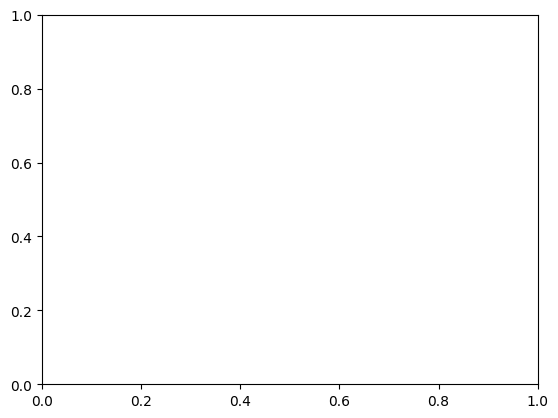

In [ ]:
animate(frames, None)

with open('statistics.pkl', 'rb') as f:
    data_tuple = pickle.load(f)

episode_duration, rewards_per_episode, average_episode_loss = data_tuple

# Plot using actual data lengths to avoid mismatched sizes
plot_statistics(list(range(len(rewards_per_episode))), rewards_per_episode, "Rewards for every episode", "Episode", "Reward")
plot_statistics(list(range(len(average_episode_loss))), average_episode_loss, "Average loss for every episode", "Episode", "Average Loss")
plot_statistics(list(range(len(episode_duration))), episode_duration, "Duration (in steps) for every episode", "Episode", "Duration")